<a href="https://colab.research.google.com/github/ddeMoivre/blog/blob/master/_notebooks/2022_02_23_Tabular_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular Modeling

> In this project we are conserned with predictive modeling of used cars prices.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/used_cars.jpg

In [1]:
#hide
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#hide
%cd /content/drive/MyDrive/Kaggle/"Used-cars price"

/content/drive/MyDrive/Kaggle/Used-cars price


In [3]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 189 kB 5.1 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 


In [4]:
#hide
#skip
![ -e /content ] && pip install -Uqq fastbook treeinterpreter waterfallcharts dtreeviz

     |████████████████████████████████| 720 kB 4.8 MB/s 
     |████████████████████████████████| 61 kB 778 bytes/s 
     |████████████████████████████████| 48 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 46.0 MB/s 
     |████████████████████████████████| 51 kB 319 kB/s 
     |████████████████████████████████| 558 kB 54.6 MB/s 
     |████████████████████████████████| 130 kB 50.9 MB/s 


In [5]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from pandas.core.common import SettingWithCopyError
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Modern machine learning can be distilled down to a couple of key techniques that are widely applicable. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

   - Ensembles of decision trees (i.e., random forests and gradient boosting machines), mainly for structured data (such as you might find in a database table at most companies)
   - Multilayered neural networks learned with SGD (i.e., shallow and/or deep learning), mainly for unstructured data (such as audio, images, and natural language)

Deep learning often gives superior resutls for unstructured data, but for many kinds of structured data these two approaches tend to give quite similar results. But ensembles of decision trees tend to train faster, are often easier to interpret, do not require special GPU hardware for inference at scale, and often require less hyperparameter tuning. 

Most importantly, the critical step of interpreting a model of tabular data is significantly easier for decision tree ensembles. There are tools and methods for answering the pertinent questions, like: Which columns in the dataset were the most important for your predictions? How are they related to the dependent variable? How do they interact with each other? And which particular features were most important for some particular observation?

Therefore, ensembles of decision trees are our first approach for analyzing a new tabular dataset.


## The Dataset

The dataset we use is the used cars dataset of [Craigslist from Kaggle](https://www.kaggle.com/austinreese/craigslist-carstrucks-data), is the world's largest collection of used vehicles for sale.

In [6]:
#hide
#!kaggle datasets download -d austinreese/craigslist-carstrucks-data

In [7]:
#hide
#!unzip \*.zip  && rm *.zip

## Look at the Data

In [8]:
df = pd.read_csv('vehicles.csv', low_memory=False)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [10]:
drop_columns = ['id', 'url', 'region_url', 'image_url', 'description', 
                'size', 'county', 'posting_date', 'VIN', 'paint_color']
df = df.drop(columns = drop_columns)

At this point, a good next step is to handle ordinal columns. This refers to columns containing strings or similar, but where those strings have a natural ordering. For instance, here are the levels of conditions:

In [11]:
df['condition'].unique()

array([nan, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage'], dtype=object)

We can tell Pandas about a suitable ordering of these levels like so:

In [12]:
conditions = 'new', 'like new', 'excellent', 'good', 'fair', 'salvage'

In [13]:
df['condition'] = df['condition'].astype('category')
df['condition'].cat.set_categories(conditions, ordered=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [14]:
df['cylinders'].unique()

array([nan, '8 cylinders', '6 cylinders', '4 cylinders', '5 cylinders', 'other', '3 cylinders', '10 cylinders', '12 cylinders'], dtype=object)

In [15]:
cylinders = '12 cylinders', '10 cylinders', '8 cylinders', '6 cylinders', '5 cylinders', 
'4 cylinders', '3 cylinders', 'other'

('4 cylinders', '3 cylinders', 'other')

In [16]:
df['cylinders'] = df['cylinders'].astype('category')
df['cylinders'].cat.set_categories(cylinders, ordered=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)




The most important data column is the dependent variable—that is, the one we want to predict. Recall that a model's metric is a function that reflects how good the predictions are. It's important to note what metric is being used for a project. Generally, selecting the metric is an important part of the project setup. 

Let's look at price column.

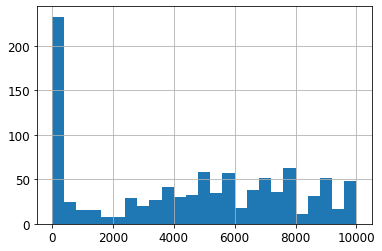

In [17]:
df[df['price']<10000]['price'].sample(n=1000, random_state=1).hist(bins=25);

In this case we will us root mean squared log error (RMSLE) between the actual and predicted prices. It is an extension on Mean Squared Error (MSE) that is mainly used when predictions have large deviations, which is the case with used cars prices. Values range from 0 up to thousands and we don't want to punish deviations in prediction as much as with MSE. 

Note that whene price is equal to zero this means pheraps that the value of price is missing. We can see this on one example.

In [18]:
np.array(df.loc[10,:])

array(['el paso', 0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'tx', nan, nan], dtype=object)

We need to do only a small amount of processing to use this: we take the log of the prices, so that rmse of that value will give us what we ultimately need:

In [19]:
dep_var = 'price'

In [20]:
cond = df.price > 0
df = df[cond]

In [21]:
try:
    df.loc[:,'price'] = np.log(df['price'])
except SettingWithCopyError:
  pass

## Decision trees

In [22]:
procs = [Categorify, FillMissing]

Categorify is a TabularProc that replaces a column with a numeric categorical column. FillMissing is a TabularProc that replaces missing values with the median of the column, and creates a new Boolean column that is set to True for any row where the value was missing.

We want to ensure that a model is able to predict the future. But it means that if we are going to have a useful validation set, we also want the validation set to be later in time than the training set. The Kaggle training data ends in 2022, so we will define a narrower training dataset which consists only of the Kaggle training data from before 2018, and we'll define a validation set consisting of data from after 2019.

In [23]:
df = df[df['year'].notnull()]

cond = (df.year<2019)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [24]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [25]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)



A TabularPandas behaves a lot like a fastai Datasets object, including providing train and valid attributes:



In [26]:
len(to.train),len(to.valid)

(350038, 42774)

In [27]:
#hide_output
to.show(3)

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,type,state,odometer_na,lat_na,long_na,year,odometer,lat,long,price
27,auburn,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,clean,other,#na#,pickup,al,False,False,False,2014.0,57923.0,32.59,-85.480003,10.421984
28,auburn,chevrolet,silverado 1500,good,8 cylinders,gas,clean,other,#na#,pickup,al,False,False,False,2010.0,71229.0,32.59,-85.480003,10.025263
30,auburn,toyota,tundra double cab sr,good,8 cylinders,gas,clean,other,#na#,pickup,al,False,False,False,2017.0,41124.0,32.59,-85.480003,10.341420


In [28]:
save_pickle('to.pkl',to)

### Creating the Decision Tree

In [29]:
#hide
to = load_pickle('to.pkl')


In [30]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

Now that our data is all numeric, and there are no missing values, we can create a decision tree:

In [31]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

To keep it simple, we've told sklearn to just create four leaf nodes. To see what it's learned, we can display the tree:

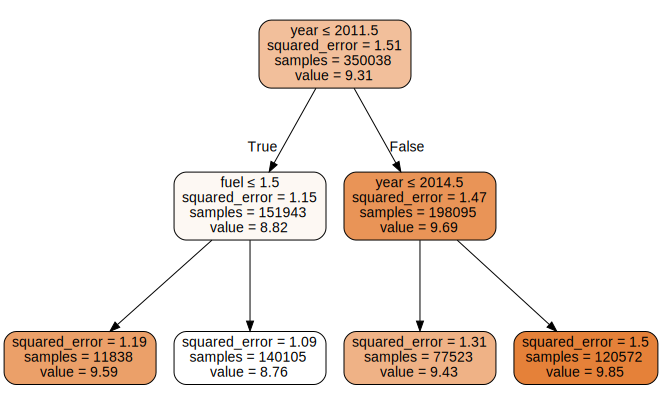

In [32]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

We can show the same information using Terence Parr's powerful dtreeviz library:

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


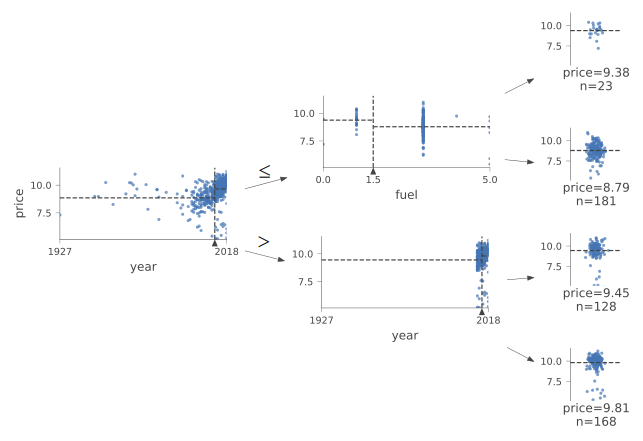

In [33]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

This shows a chart of the distribution of the data for each split point. We can clearly see that there's a problem with our year data: there are cars made in the year 1927, apparently! For modeling purposes, 1927 is fine, but as you can see this outlier makes visualization of the values we are interested in more difficult. So, let's replace it with 1980:

In [34]:
xs.loc[xs['year']<1980, 'year'] = 1980
valid_xs.loc[valid_xs['year']<1980, 'year'] = 1980

That change makes the split much clearer in the tree visualization, even although it doesn't actually change the result of the model in any significant way. This is a great example of how resilient decision trees are to data issues!

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


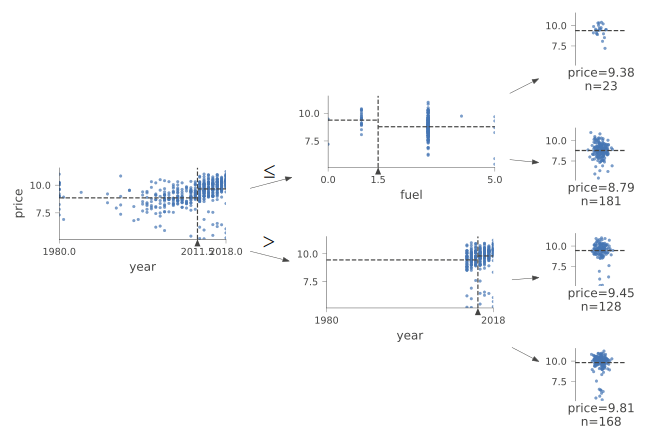

In [35]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as max_leaf_nodes:

In [36]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [37]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [38]:
m_rmse(m, xs, y)

0.102045

In [39]:
m_rmse(m, valid_xs, valid_y)

1.131917

It looks like we might be overfitting pretty badly. Here's why:

In [40]:
m.get_n_leaves(), len(xs)

(203088, 350038)

We've got too many nodes!  Indeed, sklearn's default settings allow it to continue splitting nodes until there is only one item in each leaf node. Let's change the stopping rule to tell sklearn to ensure every leaf node contains at least 25 auction records:

In [41]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.74457, 0.98132)

That looks much better. Let's check the number of leaves again:

In [42]:
m.get_n_leaves()

10655

Much more reasonable! Building a decision tree is a good way to create a model of our data. It is very flexible, since it can clearly handle nonlinear relationships and interactions between variables.

## Random Forest

In essence a random forest is a model that averages the predictions of a large number of decision trees, which are generated by randomly varying various parameters that specify what data is used to train the tree and other tree parameters. Bagging is a particular approach to "ensembling," or combining the results of multiple models together. To see how it works in practice, let's get started on creating our own random forest!

### Creating a Random Forest

In the following function definition n_estimators defines the number of trees we want, max_samples defines how many rows to sample for training each tree, and max_features defines how many columns to sample at each split point (where 0.5 means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same min_samples_leaf parameter we used in the last section. Finally, we pass n_jobs=-1 to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this chapter:

In [43]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [44]:
m = rf(xs, y);

In [45]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.582435, 0.884202)

To see the impact of n_estimators, let's get the predictions from each individual tree in our forest (these are in the estimators_ attribute):

In [46]:
import warnings
warnings.filterwarnings("ignore")

preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [47]:
r_mse(preds.mean(0), valid_y)

0.884202

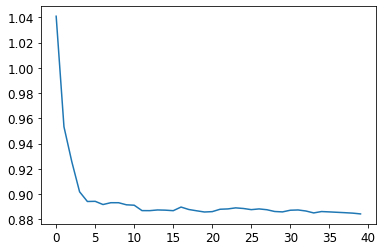

In [48]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);


## Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

   - How confident are we in our predictions using a particular row of data?
   - For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
   - Which columns are the strongest predictors, which can we ignore?
   - Which columns are effectively redundant with each other, for purposes of prediction?
   - How do predictions vary, as we vary these columns?


### Tree Variance for Prediction Confidence

In [49]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [50]:
preds.shape

(40, 42774)

In [51]:
preds_std = preds.std(0)

Here are the standard deviations for the predictions for the first five prices, that is, the first five rows of the validation set:

In [52]:
preds_std[:5]

array([0.12760513, 0.499672  , 0.89026325, 0.316399  , 0.06906902])

### Feature Importance

In [53]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)


In [54]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
14,year,0.169779
16,lat,0.147254
15,odometer,0.146727
17,long,0.116942
2,model,0.061251
3,condition,0.055504
8,drive,0.054248
5,fuel,0.048203
4,cylinders,0.038406
1,manufacturer,0.037436


A plot of the feature importances shows the relative importances more clearly:

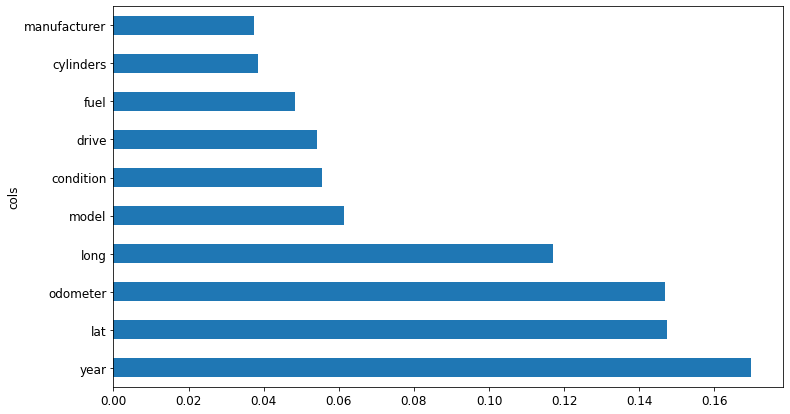

In [55]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:10]);

### Removing Low-Importance Variables

It seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results. Let's try just keeping those with a feature importance greater than 0.005:

In [56]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

15

In [57]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [58]:
m = rf(xs_imp, y)

### Removing Redundant Features

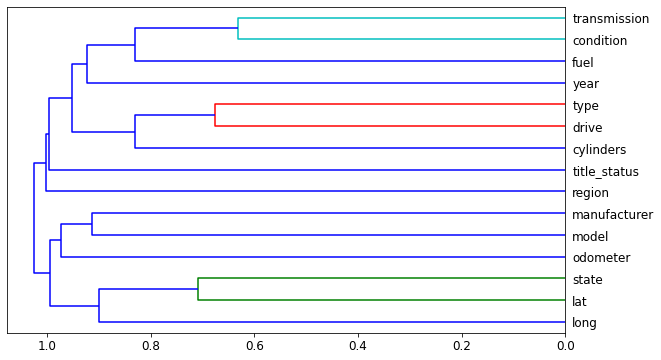

In [59]:
cluster_columns(xs_imp)

In this chart, the pairs of columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left. In our case it seams that there are no closely correlated features.

### Partial Dependence

As we've seen, the two most important predictors are year lat and odometer. We'd like to understand the relationship between these predictors and sale price. It's a good idea to first check the count of values per category (provided by the Pandas value_counts method), to see how common each category is:

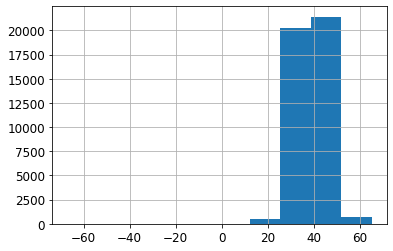

In [60]:
ax = valid_xs['lat'].hist()

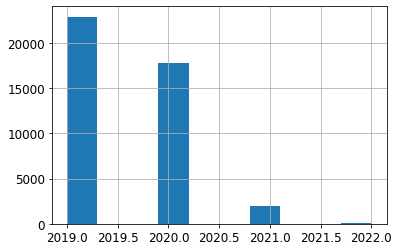

In [61]:
ax = valid_xs['year'].hist()

Partial dependence plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?

For instance, how does year impact sale price, all other things being equal?

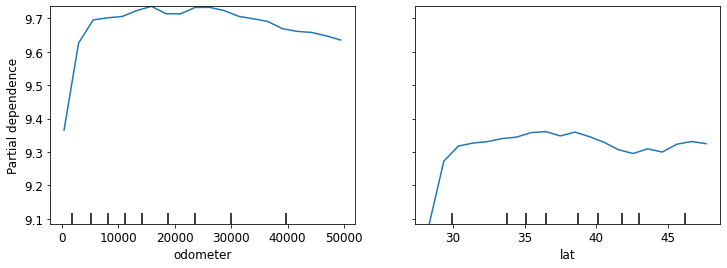

In [62]:
from sklearn.inspection import plot_partial_dependence

fig, ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_imp, ['odometer', 'lat'], grid_resolution=20, ax=ax);